In [1]:
from __future__ import division
import pandas as pd
import numpy as np

In [2]:
churn_df = pd.read_csv('D:/ex/churn.csv', ',')
col_names = churn_df.columns.tolist()

In [3]:
print ("Column names:")
print (col_names)

Column names:
['State', 'Account Length', 'Area Code', 'Phone', "Int'l Plan", 'VMail Plan', 'VMail Message', 'Day Mins', 'Day Calls', 'Day Charge', 'Eve Mins', 'Eve Calls', 'Eve Charge', 'Night Mins', 'Night Calls', 'Night Charge', 'Intl Mins', 'Intl Calls', 'Intl Charge', 'CustServ Calls', 'Churn?']


In [4]:
to_show = col_names[:6] + col_names[-6:]
#churn_df.corr()

In [5]:
print ("\nSample data:")
churn_df[to_show].head(10)


Sample data:


,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,8.41,10.1,3,2.73,3,False.
5,AL,118,510,391-8027,yes,no,9.18,6.3,6,1.70,0,False.
6,MA,121,510,355-9993,no,yes,9.57,7.5,7,2.03,3,False.
7,MO,147,415,329-9001,yes,no,9.53,7.1,6,1.92,0,False.
8,LA,117,408,335-4719,no,no,9.71,8.7,4,2.35,1,False.
9,WV,141,415,330-8173,yes,yes,14.69,11.2,5,3.02,0,False.


In [6]:
# Isolate target data
churn_result = churn_df['Churn?']
y = np.where(churn_result == 'True.',1,0)

In [7]:
# We don't need these columns
to_drop = ['State','Area Code','Phone','Churn?']
churn_feat_space = churn_df.drop(to_drop,axis=1)

In [8]:
# 'yes'/'no' has to be converted to boolean values
# NumPy converts these from boolean to 1. and 0. later
yes_no_cols = ["Int'l Plan","VMail Plan"]
churn_feat_space[yes_no_cols] = churn_feat_space[yes_no_cols] == 'yes'

In [9]:
# Pull out features for future use
features = churn_feat_space.columns


In [10]:
X = churn_feat_space.as_matrix().astype(np.float)

In [11]:
# This is important
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [12]:
print ("Feature space holds %d observations and %d features" % X.shape)
print ("Unique target labels:", np.unique(y))

Feature space holds 3333 observations and 17 features
Unique target labels: [0 1]


In [13]:
from sklearn.cross_validation import KFold

In [14]:
def run_cv(X,y,clf_class,**kwargs):
    kf = KFold(len(y),n_folds=5,shuffle=True)
    y_pred = y.copy()
    
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        
        clf = clf_class(**kwargs)
        clf.fit(X_train, y_train)
        y_pred[test_index] = clf.predict(X_test)
    return y_pred

In [15]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN

In [16]:
def accuracy(y_true,y_pred):
    # NumPy interprets True and False as 1. and 0.
    return np.mean(y_true == y_pred)

In [17]:
print ("Support vector machines:")
print ("%.3f" % accuracy(y, run_cv(X,y,SVC)))
print ("Random forest:")
print ("%.3f" % accuracy(y, run_cv(X,y,RF)))
print ("K-nearest-neighbors:")
print ("%.3f" % accuracy(y, run_cv(X,y,KNN)))

Support vector machines:
0.920
Random forest:
0.945
K-nearest-neighbors:
0.893


In [18]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

y = np.array(y)
class_names = np.unique(y)



confusion_matrices = [
    ( "Support Vector Machines", confusion_matrix(y,run_cv(X,y,SVC)) ),
    ( "Random Forest", confusion_matrix(y,run_cv(X,y,RF)) ),
    ( "K-Nearest-Neighbors", confusion_matrix(y,run_cv(X,y,KNN)) ),
]
#plt.hist(confusion_matrix(y,run_cv(X,y,SVC)) ) 
#plt.hist(confusion_matrix(y,run_cv(X,y,RF)) ) 
#plt.hist(confusion_matrix(y,run_cv(X,y,KNN)))

#plt.grid(True)
#plt.ylabel("SVC")
#plt.title("Churn")

#plt.show()

In [22]:
print (confusion_matrices)

[('Support Vector Machines', array([[2817,   33],
       [ 242,  241]])), ('Random Forest', array([[2822,   28],
       [ 153,  330]])), ('K-Nearest-Neighbors', array([[2808,   42],
       [ 303,  180]]))]


In [23]:
def run_prob_cv(X, y, clf_class, **kwargs):
    kf = KFold(len(y), n_folds=5, shuffle=True)
    y_prob = np.zeros((len(y),2))
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        # Predict probabilities, not classes
        y_prob[test_index] = clf.predict_proba(X_test)
    return y_prob

In [24]:
import warnings
warnings.filterwarnings('ignore')

In [25]:
# Use 10 estimators so predictions are all multiples of 0.1
pred_prob = run_prob_cv(X, y, RF, n_estimators=10)
pred_churn = pred_prob[:,1]
is_churn = y == 1

In [26]:
# Number of times a predicted probability is assigned to an observation
counts = pd.value_counts(pred_churn)


In [27]:
# calculate true probabilities
true_prob = {}
for prob in counts.index:
    true_prob[prob] = np.mean(is_churn[pred_churn == prob])
    true_prob = pd.Series(true_prob)


In [28]:
# pandas-fu
counts = pd.concat([counts,true_prob], axis=1).reset_index()
counts.columns = ['pred_prob', 'count', 'true_prob']
counts

,pred_prob,count,true_prob
0,0.0,1805,0.024931
1,0.1,680,0.042647
2,0.2,266,0.052632
3,0.3,113,0.159292
4,0.8,92,0.945652
5,0.9,84,0.988095
6,0.4,66,0.348485
7,1.0,61,1.000000
8,0.7,57,0.877193
9,0.6,57,0.736842


In [36]:
from ggplot import *
%matplotlib inline

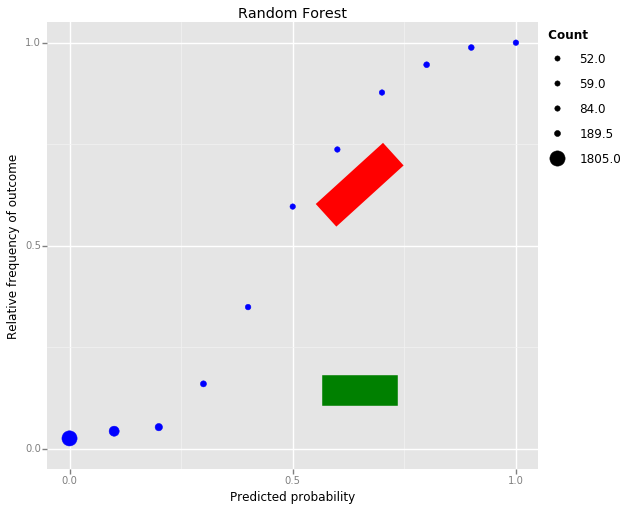

<ggplot: (-9223372036828018614)>

In [39]:
baseline = np.mean(is_churn)
ggplot(counts,aes(x='pred_prob',y='true_prob',size='count')) + \
    geom_point(color='blue') + \
    stat_function(fun = lambda x: x, color='red') + \
    stat_function(fun = lambda x: baseline, color='green') + \
    xlim(-0.05,  1.05) + ylim(-0.05,1.05) + \
    ggtitle("Random Forest") + \
    xlab("Predicted probability") + ylab("Relative frequency of outcome")
    
#Predicted probability - Прогнозируемая вероятность    
#Relative frequency of outcome- Относительная частота результата

In [31]:
from sklearn.cross_validation import train_test_split

train_index,test_index = train_test_split(churn_df.index)
clf = SVC(probability=True)
clf.fit(X[train_index],y[train_index])

test_churn_df = churn_df.ix[test_index]
test_churn_df.to_csv("D:/ex/test_churn_2.csv")
counts.to_csv("D:/ex/COUNTS_TEST.tab")

In [32]:
churn_df.corr()

,Account Length,Area Code,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
Account Length,1.000000,-0.012463,-0.004628,0.006216,0.038470,0.006214,-0.006757,0.019260,-0.006745,-0.008955,-0.013176,-0.008960,0.009514,0.020661,0.009546,-0.003796
Area Code,-0.012463,1.000000,-0.001994,-0.008264,-0.009646,-0.008264,0.003580,-0.011886,0.003607,-0.005825,0.016522,-0.005845,-0.018288,-0.024179,-0.018395,0.027572
VMail Message,-0.004628,-0.001994,1.000000,0.000778,-0.009548,0.000776,0.017562,-0.005864,0.017578,0.007681,0.007123,0.007663,0.002856,0.013957,0.002884,-0.013263
Day Mins,0.006216,-0.008264,0.000778,1.000000,0.006750,1.000000,0.007043,0.015769,0.007029,0.004323,0.022972,0.004300,-0.010155,0.008033,-0.010092,-0.013423
Day Calls,0.038470,-0.009646,-0.009548,0.006750,1.000000,0.006753,-0.021451,0.006462,-0.021449,0.022938,-0.019557,0.022927,0.021565,0.004574,0.021666,-0.018942
Day Charge,0.006214,-0.008264,0.000776,1.000000,0.006753,1.000000,0.007050,0.015769,0.007036,0.004324,0.022972,0.004301,-0.010157,0.008032,-0.010094,-0.013427
Eve Mins,-0.006757,0.003580,0.017562,0.007043,-0.021451,0.007050,1.000000,-0.011430,1.000000,-0.012584,0.007586,-0.012593,-0.011035,0.002541,-0.011067,-0.012985
Eve Calls,0.019260,-0.011886,-0.005864,0.015769,0.006462,0.015769,-0.011430,1.000000,-0.011423,-0.002093,0.007710,-0.002056,0.008703,0.017434,0.008674,0.002423
Eve Charge,-0.006745,0.003607,0.017578,0.007029,-0.021449,0.007036,1.000000,-0.011423,1.000000,-0.012592,0.007596,-0.012601,-0.011043,0.002541,-0.011074,-0.012987
Night Mins,-0.008955,-0.005825,0.007681,0.004323,0.022938,0.004324,-0.012584,-0.002093,-0.012592,1.000000,0.011204,0.999999,-0.015207,-0.012353,-0.015180,-0.009288


In [33]:
churn_df.describe()

,Account Length,Area Code,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


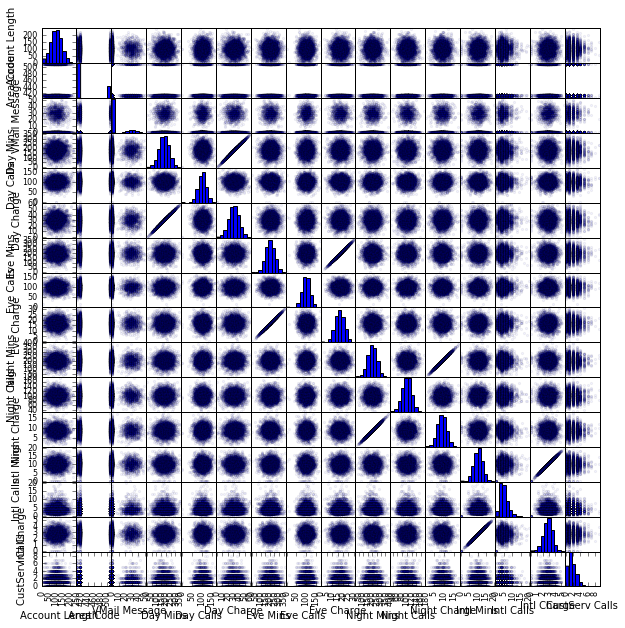

In [35]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix(churn_df, alpha=0.05, figsize=(10, 10));